In [1]:
#import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split  
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

c:\Users\finav\anaconda3\envs\gpu_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Check if CUDA is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ColorJitter(brightness=(1.2,1.4)), transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

In [4]:
# Load the entire dataset
full_dataset = datasets.ImageFolder(root='PlantVillage', transform=transform)

In [5]:
def show_images(dataset, num_images):
    # Calculate the number of rows and columns
    num_rows = 2
    num_cols = num_images // num_rows if num_images % num_rows == 0 else (num_images // num_rows) + 1
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*3, num_rows*3))
    axes = axes.flatten()  # Flatten the array to make iteration easier
    
    for i in range(num_images):
        # Get a random index
        idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[idx]
        
        if i < len(axes):  # Check to avoid IndexError if num_images is odd
            ax = axes[i]
            ax.imshow(img.permute(1, 2, 0))  
            ax.set_title(f"Label: {dataset.classes[label]}")
            ax.axis('off')
    
    # Hide any unused axes if num_images is odd
    if num_images % num_rows != 0:
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


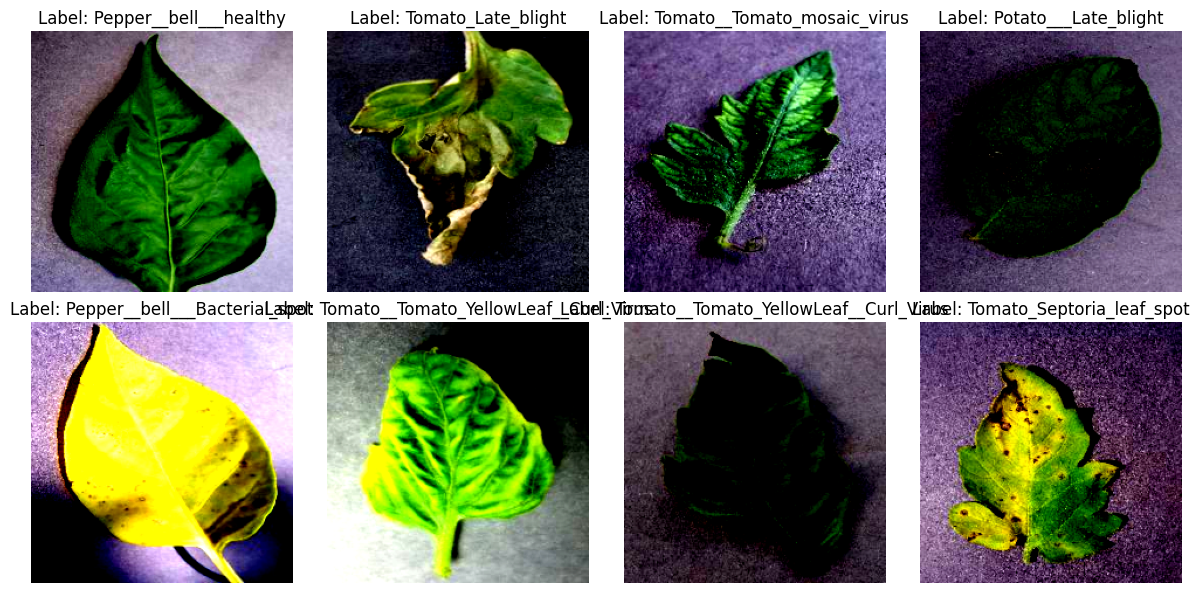

In [6]:
show_images(full_dataset, 8)

In [7]:
num_classes = len(full_dataset.classes)
print(f"Total number of classes: {num_classes}")
print("Class names:")
for class_name in full_dataset.classes:
    print(class_name)

Total number of classes: 15

Class names:

Pepper__bell___Bacterial_spot

Pepper__bell___healthy

Potato___Early_blight

Potato___Late_blight

Potato___healthy

Tomato_Bacterial_spot

Tomato_Early_blight

Tomato_Late_blight

Tomato_Leaf_Mold

Tomato_Septoria_leaf_spot

Tomato_Spider_mites_Two_spotted_spider_mite

Tomato__Target_Spot

Tomato__Tomato_YellowLeaf__Curl_Virus

Tomato__Tomato_mosaic_virus

Tomato_healthy


In [8]:
# Split the dataset into train and test
train_size = int(0.7 * len(full_dataset))
test_size = int(0.1 * len(full_dataset))
validation_size = len(full_dataset) - train_size - test_size
train_dataset, test_dataset, validation_dataset = random_split(full_dataset, [train_size, test_size, validation_size])

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [10]:
class CNN(nn.Module):
    def __init__(self, num_classes=15):
        super(CNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        # Third convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        # Fourth convolutional layer
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(256 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        # Flatten the tensor for the fully connected layer
        x = x.view(-1, 256 * 14 * 14)
        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
model = CNN(num_classes=15).to(device)

In [12]:
#Define loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
import time

In [14]:
%%time

num_epochs = 100
train_losses = []
validation_losses = []  
train_accuracies = []
validation_accuracies = []

# Variables to store predictions and actual labels for classification report
y_pred = []
y_true = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Test the model
    model.eval()
    running_loss_validation = 0.0
    correct_validation = 0
    total_validation = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss_validation += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()

            # Save predictions and true labels for classification report
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    validation_loss = running_loss_validation / len(validation_loader)
    validation_losses.append(validation_loss)
    validation_acc = 100 * correct_validation / total_validation
    validation_accuracies.append(validation_acc)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_acc:.2f}%')

    # Check for early stopping condition based on test accuracy
    if validation_acc == 100:
        print(f'Stopping early as validation accuracy reached 100%: {validation_acc:.2f}%')
        break

Epoch 1, Train Loss: 1.7518, Train Accuracy: 66.84%, Validation Loss: 0.5594, Validation Accuracy: 81.40%

Epoch 2, Train Loss: 0.4980, Train Accuracy: 83.36%, Validation Loss: 0.4078, Validation Accuracy: 86.82%

Epoch 3, Train Loss: 0.3596, Train Accuracy: 88.10%, Validation Loss: 0.3518, Validation Accuracy: 88.76%

Epoch 4, Train Loss: 0.2992, Train Accuracy: 90.07%, Validation Loss: 0.3637, Validation Accuracy: 87.99%

Epoch 5, Train Loss: 0.2532, Train Accuracy: 91.51%, Validation Loss: 0.2576, Validation Accuracy: 91.60%

Epoch 6, Train Loss: 0.2250, Train Accuracy: 92.65%, Validation Loss: 0.2382, Validation Accuracy: 93.02%

Epoch 7, Train Loss: 0.1821, Train Accuracy: 93.96%, Validation Loss: 0.2782, Validation Accuracy: 91.35%

Epoch 8, Train Loss: 0.1648, Train Accuracy: 94.46%, Validation Loss: 0.3083, Validation Accuracy: 91.35%

Epoch 9, Train Loss: 0.1510, Train Accuracy: 95.04%, Validation Loss: 0.1957, Validation Accuracy: 94.02%

Epoch 10, Train Loss: 0.1125, Train A

In [15]:
print('Train Accuracy:', train_acc)

Train Accuracy: 99.72312590849312


In [16]:
print('Validation Accuracy:', validation_acc)

Validation Accuracy: 96.41559699685153


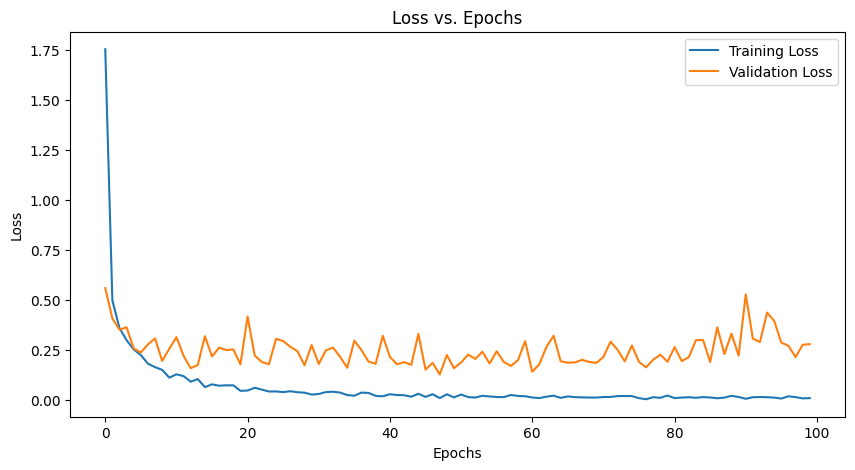

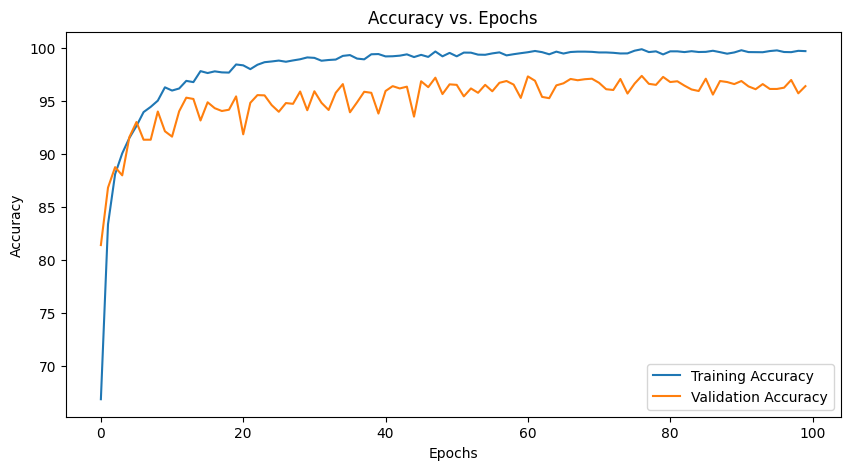

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
model.eval()

# Variables to keep track of loss, accuracy, and predictions
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Append predictions and actual labels for classification report
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate and print average loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Print classification report
print(classification_report(all_labels, all_preds, target_names=test_loader.dataset.dataset.classes))

Test Loss: 0.2955, Test Accuracy: 96.61%

                                             precision    recall  f1-score   support



              Pepper__bell___Bacterial_spot       0.99      1.00      1.00       101

                     Pepper__bell___healthy       0.98      0.98      0.98       126

                      Potato___Early_blight       0.96      1.00      0.98       102

                       Potato___Late_blight       0.97      0.93      0.95       106

                           Potato___healthy       0.92      0.92      0.92        12

                      Tomato_Bacterial_spot       0.99      0.98      0.98       202

                        Tomato_Early_blight       0.96      0.78      0.86       102

                         Tomato_Late_blight       0.92      0.98      0.95       208

                           Tomato_Leaf_Mold       0.96      0.97      0.96       123

                  Tomato_Septoria_leaf_spot       0.98      0.93      0.96       162

Tomato_Spi

In [19]:
def show_sample_predictions(test_loader, num_images=2):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images*5, 5))
    
    for i in range(num_images):
        idx = np.random.randint(len(images))
        img, label, pred = images[idx].cpu(), labels[idx].cpu(), preds[idx].cpu()
        
        ax = axes[i]
        img = img.permute(1, 2, 0)  
        ax.imshow(img.numpy())
        ax.set_title(f"Original: {test_loader.dataset.dataset.classes[label]}\nPredicted: {test_loader.dataset.dataset.classes[pred]}")
        ax.axis('off')
    
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


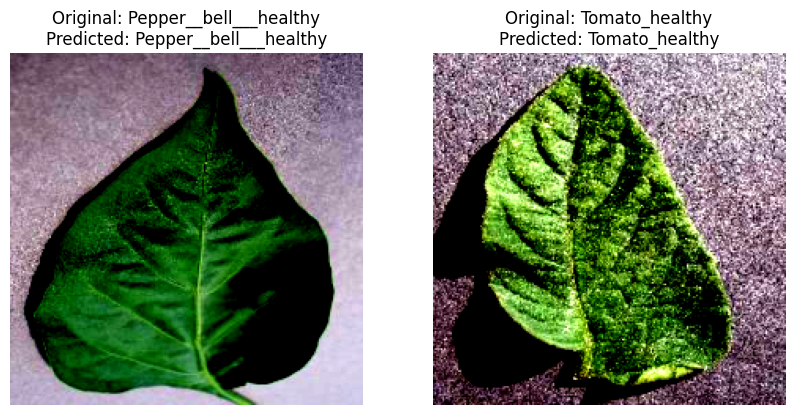

In [20]:
# Call the function to display sample predictions
show_sample_predictions(test_loader)

In [21]:
# Save the model state
model_path = 'model_state_dict_cnn.pth'
torch.save(model.state_dict(), model_path)

In [22]:
# Save the entire model
model_path_complete = 'complete_model_cnn.pth'
torch.save(model, model_path_complete)